In [975]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output as clr
import os
import numpy as np
from scipy.special import beta as BETA
import time

In [943]:
device = "cpu"
if(torch.cuda.is_available()):
    deivce = "gpu"

torch.autograd.set_detect_anomaly(True)
plt.set_cmap("gray")

<Figure size 432x288 with 0 Axes>

In [944]:
class IBP:
    def __init__(self, alpha):
        self.alpha = alpha
    
    def rand(self, n, k_max):
        Z = []
        for i in range(n):
            nu = torch.distributions.beta.Beta(self.alpha,1).sample([k_max,1])
            p = self.break_stick_ibp(nu)
            z = torch.distributions.bernoulli.Bernoulli(p).sample().view(1,-1)
            Z.append(z)
        
        Z = torch.cat(Z, 0)
        return Z
    
    def rand_nu(self, nu, n= 1):
        p = self.break_stick_ibp(nu)
        Z = torch.distributions.bernoulli.Bernoulli(p).sample([n])
        return Z
    
    def break_stick_ibp(self, nu):
        K_max = nu.shape[0]
        p = []
        p.append(nu[0,:])
        for k in range(1,K_max):
            p.append(p[k-1]*nu[k,:])
        
        p = torch.cat(p,0)
        return p
        
    def break_log_stick_ibp(self, lognu):
        K_max = nu.shape[0]
        logp = []
        logp.append(lognu[0,:])
        for k in range(1,K_max):
            logp.append(logp[k-1] + lognu[k,:])
        
        logp = torch.cat(logp, 0)
        return logp

In [945]:
import math
import torch
from torch.optim.optimizer import Optimizer



class Adam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data#.clamp(-10,10)
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = torch.zeros_like(p.data)
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                val = (grad!=0).float()
                state['step'] += 1# val

                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * (bias_correction2.pow(0.5)) / bias_correction1

                p.data += -step_size*(exp_avg.div(denom))

        return loss

In [946]:
# training
BATCH_SIZE = 100
if(os.path.isdir(os.path.join(os.getcwd(), 'data'))):
    trainset = datasets.MNIST('./data/', train=True, download=False,
                   transform=transforms.ToTensor())
else:
    trainset = datasets.MNIST('./data/', train=True, download=True,
                   transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
print("Done !")

Done !


tensor(0.)
tensor(1.)


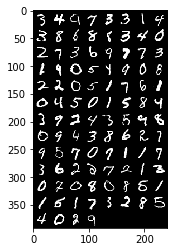

In [947]:
def show_images(images):
    images = torchvision.utils.make_grid(images)
    show_image(images[0])
    print(images.min())
    print(images.max())

def show_image(img):
    plt.imshow(img, cmap='gray')

dataiter = iter(trainloader)
images, labels = dataiter.next()
show_images(images)

In [948]:
class RRSIBPVAE(nn.Module):
    def __init__(self, latent_variable_dim, prior , rholr = 10e-12, lr = 0.01):
        super(RRSIBPVAE, self).__init__()
        
        alpha = prior.alpha
        self.prior = prior
        self.print = False
        self.sp = torch.nn.Softplus(threshold = 20)
        
        ### Global Params
        self.eps1 = torch.tensor(10e-6).float()
        self.eps2 = torch.tensor(10e-4).float()
        self.lr = lr
        self.D = 784
    
        # Encoder
        self.h_dim = 400
        self.fc1 = nn.Linear(self.D,self.h_dim,'relu')
        
        self.weight_enc_mean = nn.Parameter(torch.randn(latent_variable_dim, self.h_dim)*0.0001*self.eps1)
        self.weight_enc_std = nn.Parameter(torch.randn(latent_variable_dim, self.h_dim)*0.0001*self.eps1)
        self.bias_enc_mean = nn.Parameter(torch.randn(latent_variable_dim, 1)*0.0001*self.eps1)
        self.bias_enc_std = nn.Parameter(torch.randn(latent_variable_dim, 1)*0.0001*self.eps1)
        
        
        # Decoder
        self.weight_dec_code = nn.Parameter(torch.randn(self.h_dim, latent_variable_dim, )*0.0001*self.eps1)
        self.bias_dec_code = nn.Parameter(torch.randn(self.h_dim, 1)*0.0001*self.eps1)
        self.fc2 = nn.Linear(self.h_dim,self.D,'linear')
        
        
        # structured SBC
        self.aeys = nn.Parameter(torch.zeros(latent_variable_dim, 1) + self.inv_softplus(alpha) + torch.rand(latent_variable_dim,1)*0.0001*self.eps1)
        self.bees = nn.Parameter(torch.zeros(latent_variable_dim, 1) + self.inv_softplus(torch.tensor(1.0)) + torch.rand(latent_variable_dim,1)*0.0001*self.eps1)
        self.alpha = alpha
        self.beta = 1.0
        
        
        self.unif_sampler = torch.distributions.uniform.Uniform(self.eps1, 1-self.eps1)
        self.euler_constant = -torch.digamma(torch.tensor(1.0))
        
        # Z : GumbelBernoulli
        self.phi = nn.Parameter(torch.randn((self.h_dim + 1),latent_variable_dim)*0.0001*self.eps1)
        self.temperature = torch.zeros(latent_variable_dim, 1) + 10
        self.t_prior = 0.1 # prior lambda

        ### Russian Roulette part
        self.rhos = torch.zeros(latent_variable_dim + 1,1) + 0.5
        self.rholr = rholr
        
        ## Optimizer
        self.optimizer = None
        self.K = latent_variable_dim
        self.max_K = latent_variable_dim
        
        
        
                             
    def inv_softplus(self, alpha):
#         return self.sp(alpha)
        with torch.no_grad():
            mask = (alpha <= 20).float()
            
        ret = alpha*(1-mask) + torch.log(torch.exp(alpha) - 1)*mask
        return ret
        
    def softplus(self, x):
#         return torch.log(torch.exp(x) + 1)
        with torch.no_grad():
            mask = (x <= 20).float()
        ret = x*(1-mask) + torch.log(torch.exp(x) + 1)*mask
        return ret
    
    def sample_nupi(self, N, K, sample_size = 1):
        
        a = self.softplus(self.aeys)[:K,:].view(K,1)
        b = self.softplus(self.bees)[:K,:].view(K,1)
        
        U = self.unif_sampler.sample([K,sample_size])
        nu = (1-(U+self.eps1).pow(1/a) + self.eps1 ).pow(1/b).view(1,-1, sample_size)[0]
        py = self.prior.rand_nu(nu, N).view(N,-1, sample_size)
        
        return nu, py
        
    
    def GumbelBernoulliLogitLazyDense(self, x, k):
        
        N, D = x.shape
        
        x_cat = torch.cat((x.view(N,self.h_dim), torch.ones(N).view(N,-1)), 1).view(N,D+1)
        inter_z = torch.mm(x_cat, self.phi[:,:k])
        z, gi, pi, py = self.reparameterize_gumbel_kumaraswamy(inter_z, k) # N x K
        return z, gi, pi, py
        
    def reparameterize_gaussian(self, log_var, mu):
        s = torch.exp(0.5*log_var)
        eps = torch.rand_like(s) # generate a iid standard normal same shape as s
        return eps.mul(s).add_(mu)
    
    def reparameterize_gumbel_kumaraswamy(self, inter_z, p):
        '''Proper Sampling is required with masking'''
        
        N, K = inter_z.shape
        sample_size = 1
        
        G1 = self.unif_sampler.sample([N,K,sample_size])
        logit_G1 = G1.log() - (1-G1).log() 
        
        nu, pi = self.sample_nupi(N, K,sample_size) # K x sample_size
        
        logit_pi = ((pi + self.eps1)/(1-pi + self.eps1)).log()
        logit_alpha = logit_pi + inter_z.view(N,K,1)
        alpha = logit_alpha.sigmoid()
        
        z1 = (logit_alpha + logit_G1)/self.temperature[:K,:].view(1,K,1)
        y = z1.sigmoid()
        
        return y, alpha, pi, nu
        
    def forward(self, input, k):
        x = input.view(-1, self.D)
        N, D = x.shape
        
        if(k == 0):
            k = self.get_current_K()
            
        z, gi, pi, py, a, mu, log_var = self.encode(x,k)
        x = self.decode(a, z.mean(dim=-1).view(N,k), k)
        return x, z, gi, pi, py, a, mu, log_var
    
    
    def encode(self, x, k):
        
        h = self.fc1(x)
        log_s = ((F.linear(h, self.weight_enc_std[:k,:]) + self.bias_enc_std[:k,:].view(-1,k))/100)#.clamp(0,100)
        mu = F.linear(h, self.weight_enc_mean[:k,:]) + self.bias_enc_mean[:k,:].view(-1,k)
        
        a = self.reparameterize_gaussian(log_s, mu) # N x K
        
        z, gi, pi, py = self.GumbelBernoulliLogitLazyDense(h, k)
        return z,gi,pi,py,a,mu,log_s

    
    def decode(self, a, z, k):
        
        code = a*z
        x = F.linear(code, self.weight_dec_code[:,:k]) + self.bias_dec_code.view(-1,self.h_dim)
        x = F.relu(x)
        x = self.fc2(x).sigmoid()
        
        return x
    
    
    def add_k_node(self, k):
        
        # Add k latent features ...
        if(k == 0):
            return 
        with torch.no_grad():
            self.aeys = nn.Parameter(torch.cat((self.aeys, torch.rand(k,1)*0.0001*self.eps1 + self.softplus(self.alpha)), 0))
            self.bees = nn.Parameter(torch.cat((self.bees, torch.rand(k,1)*0.0001*self.eps1 + self.softplus(torch.tensor(1.0))), 0))
            
            self.phi = nn.Parameter(torch.cat((self.phi, torch.randn((self.h_dim + 1),k)), 1))
            self.weight_enc_mean = nn.Parameter(torch.cat((self.weight_enc_mean, torch.randn(k, self.h_dim)), 0)*0.0001*self.eps1)
            self.weight_enc_std = nn.Parameter(torch.cat((self.weight_enc_std, torch.randn(k, self.h_dim)), 0)*0.0001*self.eps1)
            
            self.bias_enc_mean = nn.Parameter(torch.cat((self.bias_enc_mean, torch.randn(k, 1)), 0)*0.0001*self.eps1)
            self.bias_enc_std = nn.Parameter(torch.cat((self.bias_enc_std, torch.randn(k, 1)), 0)*0.0001*self.eps1)
            
            self.weight_dec_code = nn.Parameter(torch.cat((self.weight_dec_code, torch.randn(self.h_dim,k)), 1)*0.0001*self.eps1)
            
            self.rhos = torch.cat((self.rhos, torch.zeros(k,1) + 0.5), 0)
            self.temperature = torch.cat((self.temperature, torch.zeros(k,1) + 10.0), 0)
            
            
    
    def del_k_node(self, k):
        
        # Retain k Latent Features ...
        if(k == 0 or k == self.get_current_K()):
            return
        with torch.no_grad():
            c_K = self.get_current_K()
            
            self.aeys = nn.Parameter(list(torch.split(self.aeys, c_K - k , 0))[0])
            self.bees = nn.Parameter(list(torch.split(self.bees, c_K - k , 0))[0])
            
            self.phi = nn.Parameter(list(torch.split(self.phi, c_K - k , 1))[0])
            self.weight_enc_mean = nn.Parameter(list(torch.split(self.weight_enc_mean, c_K - k , 0))[0])
            self.weight_enc_std = nn.Parameter(list(torch.split(self.weight_enc_std, c_K - k , 0))[0])
            self.weight_dec_code = nn.Parameter(list(torch.split(self.weight_dec_code, c_K - k , 1))[0])
            
            self.rhos = list(torch.split(self.rhos, c_K - k + 1, 0))[0]
                             
    def get_current_K(self):
        return self.K
    
    def constraint_proj(self):
        with torch.no_grad():
            self.aeys[self.aeys < 0.1] = 0.1
            self.bees[self.bees < 0.1] = 0.1
            self.rhos[self.rhos < 10e-6] = 10e-6
            self.rhos[self.rhos > 1 - 10e-6] = 1 - 10e-6
            pass
        
    def dynamize_Adam(self, reset = False, amsgrad = True):
        with torch.no_grad():
            if(reset or self.optimizer == None):
                self.optimizer = Adam(self.parameters(), self.lr, amsgrad = amsgrad)
                self.optimizer.step()
            else:
                optim = self.optimizer
                newoptim = Adam(self.parameters(), self.lr)

                for i in range(len(optim.param_groups)):
                    group_old = optim.param_groups[i]
                    group_new = newoptim.param_groups[i]

                    for j in range(len(group_old['params'])):
                        params_old = group_old['params'][j]
                        params_new = group_new['params'][j]

                        amsgrad = group_old['amsgrad']
                        newoptim.param_groups[i]['amsgrad'] = amsgrad


                        state_old = optim.state[params_old]
                        state_new = newoptim.state[params_new]

                        state_new['step'] = torch.zeros_like(params_new.data)

                        state_new['exp_avg'] = torch.zeros_like(params_new.data)
                        state_new['exp_avg_sq'] = torch.zeros_like(params_new.data)



                        exp_avg = state_new['exp_avg']
                        exp_avg_sq = state_new['exp_avg_sq']
                        max_exp_avg_sq = None
                        if(amsgrad):
                            state_new['max_exp_avg_sq'] = torch.zeros_like(params_new.data)
                            max_exp_avg_sq = state_new['max_exp_avg_sq']
                            
                        if(len(state_old) == 0):
                            pass
                        else:
                            if(len(state_old['exp_avg'].shape)==2):
                                no,do = state_old['exp_avg'].shape
                                exp_avg[:no,:do] = state_old['exp_avg']
                                exp_avg_sq[:no,:do] = state_old['exp_avg_sq']
                                if(max_exp_avg_sq is not None):
                                    max_exp_avg_sq[:no,:do] = state_old['max_exp_avg_sq']
                                state_new['step'][:no,:do] = state_old['step']

                            elif(len(state_old['exp_avg'].shape)==1):
                                no = state_old['exp_avg'].shape[0]
                                exp_avg[:no] = state_old['exp_avg']
                                exp_avg_sq[:no] = state_old['exp_avg_sq']
                                if(max_exp_avg_sq is not None):
                                    max_exp_avg_sq[:no] = state_old['max_exp_avg_sq']
                                state_new['step'][:no] = state_old['step']

                            else:
                                assert 1 == 2 ,'error in dynamic adam'

                        state_new['exp_avg'] = exp_avg
                        state_new['exp_avg_sq'] = exp_avg_sq

                        newoptim.state[params_new] = state_new
                    
                self.optimizer = newoptim

In [949]:
def retain_k_nodes(model , new_K = 0):
    
    current_K = model.max_K
    if(current_K < new_K):
        model.add_k_node(new_K - current_K)
        model.max_K = new_K
    elif(current_K > new_K):
        model.del_k_node(current_K - new_K)
    else:
        pass
    
    model.K = new_K

In [950]:
def rrs_loss(model, images, one_minus_rho, fixed = False, printf = True):
    
    curr_K = model.K
    l = torch.zeros(curr_K+1,1)
    one_minus_rho = one_minus_rho.view(-1,1)
    weight = torch.zeros_like(one_minus_rho)
    weight[curr_K] = one_minus_rho[curr_K]
    for i in range(1,curr_K+1):
        weight[curr_K-i] = weight[curr_K-i+1] + one_minus_rho[curr_K - i]
        
    weight = weight[1:]
    
    N = images.shape[0]
    global_multiplier = (N/60000)*1000
    
    _, z, gi, pi, nu, a_code, mu, log_var = model(images, 0)
    
    
    softplus = model.sp
    eps = model.eps1
        
    
    ## KL Gauss A for code
    KL_gauss = (-0.5*(1 + log_var - mu.pow(2) - log_var.exp()).view(N,curr_K).mean(dim = 0).view(1,-1))
#     print((KL_gauss != KL_gauss).sum())
    KL_gauss[KL_gauss != KL_gauss] = 0
    l[1:,:]  += KL_gauss.view(curr_K,1)
    KL_gauss_w = (KL_gauss*weight.view(1,-1)).sum()
        
        
    ## KL Kumaraswamy Distribution to Beta prior for nu's
    a = model.softplus(model.aeys)[:curr_K,:].view(curr_K,1)
    b = model.softplus(model.bees)[:curr_K,:].view(curr_K,1)
        
    KL_kuma = ((a - model.alpha)/(a))*(-model.euler_constant -torch.digamma(b) - 1/b)
    KL_kuma += (a.log() + b.log()) + torch.log(torch.tensor(BETA(model.alpha,1)))
    KL_kuma -= (b - 1)/(b) 
    KL_kuma[KL_kuma != KL_kuma] = 0
    KL_kuma = (KL_kuma*global_multiplier).view(1,-1) # K 
    l[1:,:] += KL_kuma.view(curr_K,1)
    KL_kuma_w = (KL_kuma[:,:curr_K]*weight.view(1,-1)).sum()
    
    
    ## KL between conditional distrbution of Z to IBP prior on nu : (stick breaking )
    logit_pi = (pi+eps).log() - (1-pi+eps).log()
    logit_x  =  (z+eps).log() - (1 -z+eps).log()
    logit_gi = (gi+eps).log() - (1-gi+eps).log()

    
    tau = model.temperature[:curr_K,:].view(1,curr_K,1)
    tau_prior = model.t_prior
    
#     print(logit_pi.shape, tau.shape)
    
    exp_term_p = logit_pi - logit_x*(tau)
    exp_term_q = logit_gi - logit_x*(tau)
    log_tau = torch.log(torch.tensor(tau, requires_grad = False))
    log_taup = torch.log(torch.tensor(tau_prior, requires_grad = False))
    
    
#     print(exp_term_p.max(), exp_term_q.max())
    
    log_pz = log_tau + exp_term_p - 2.0*softplus(exp_term_p)
    log_qz = log_tau + exp_term_q - 2.0*softplus(exp_term_q)
    
    qz = log_qz.exp()
    KL_gumb = (log_qz - log_pz)
    
    
    KL_gumb[KL_gumb != KL_gumb] = 0
#     KL_gumb[KL_gumb < 0] = 0
    KL_gumb = 0.01*KL_gumb.mean(dim =-1).mean(dim = 0).view(1,-1)#.abs()
    l[1:,:] += KL_gumb.view(curr_K,1)
    KL_gumb_w = (KL_gumb*weight.view(1,-1)).sum()
    
    
    
    #likelihood 
    
    lik_loss = 0
    for i in range(1,curr_K+1):
        sigma2X = 0.01
        recon_image = model.decode(a_code[:,:i], z[:,:i,:].mean(dim=-1).view(N,i), i)
        logity = ((recon_image + eps).log() - (1 - recon_image + eps).log()).view(-1,model.D)
        Lik = images.view(-1,model.D)*logity - softplus(logity)
#         Lik = -F.binary_cross_entropy(recon_image, images.view(-1, model.D), reduction='sum')
        
        Lik = torch.sum(Lik)/(N)

        lik_loss += Lik*one_minus_rho[i]
        l[i,:] -= Lik
        
    
    l_final = - lik_loss + KL_gumb_w + KL_kuma_w  + KL_gauss_w
#     KL_gauss_w = 0
    if(printf and model.print):
        print(lik_loss/one_minus_rho.sum() , KL_gumb_w , KL_kuma_w, KL_gauss_w)
    if(not fixed):
        return l, one_minus_rho, l_final
    else:
        return l, one_minus_rho,  KL_gumb[:-1,:].sum() + KL_kuma[:-1,:].sum() + l[-1,:].sum() + KL_gauss[:-1,:].sum() 

In [969]:
def train_step(model, images, sample_max = 5, sample = False, keep_graph = False):
    
    """ sample a trucation level and then do the same"""
    
    curr_K = model.get_current_K()
    model.rhos[0] = 1.0
    
    with torch.no_grad():
        rhos = list(model.rhos)[:curr_K+1]
        L = len(rhos)
        samples = []
    
        for i in range(sample_max):

            k = 1

            while(True):
                u = np.random.uniform()
                if(u > rhos[k]):
                    samples.append(k)
                    break
                k += 1

                if(k > L-1 and sample):
                    rhos.append(0.5)
                    L = len(rhos)
                elif(k > L-1):
                    break
                
    samples.sort()
    if(sample):
        curr_K = model.get_current_K()
        new_value = int(np.max(samples[-5:]))
        
        if(new_value > model.max_K):
            model.optimizer = retain_k_nodes(model , new_K = new_value)
            model.K = new_value
            model.max_K = new_value
            model.dynamize_Adam()
        else:
            retain_k_nodes(model , new_K = model.max_K)
            model.K = new_value
            
    else:
        new_value = curr_K
        
    with torch.no_grad():
        curr_K = model.K
        while(len(rhos)<curr_K+1):
            rhos.append(0.5)
        omrho = 1 - np.array(rhos)[:curr_K+1]
        weight = omrho*0
        for i in range(len(samples)):
            val = samples[i]+1
            weight[:val] += omrho[:val]
        weight/=len(samples)
        weightf = torch.tensor(weight).view(1,-1).float()

        if(model.print):
            print("Current Truncated Level :", new_value)
            print(model.rhos)
        
    model.optimizer.zero_grad()
    curr_K = model.get_current_K()
    
    l ,one_minus_rho, l_final_params = rrs_loss(model, images, weightf[:,:curr_K+1], fixed = False)
    
    
    
#     num_cal = 5
#     L = []
#     OMR = []
#     LF = []
    
#     for i in range(num_cal):
#         printf = False
#         if(i == 0):
#             printf = True
            
#         lo ,one_minus_rhoo, l_final_paramso = rrs_loss(model, images, weightf[:,:curr_K+1], fixed = False, printf = printf)
        
#         L.append(lo.view(1,curr_K+1,-1))
#         OMR.append(one_minus_rhoo.view(1,curr_K+1,-1))
#         LF.append(l_final_paramso.view(1,-1))
        
    
#     num_cal = torch.tensor([num_cal]).float()
#     l = torch.cat(L, 0).sum(dim = 0).view(curr_K+1, - 1)/num_cal
#     one_minus_rho = torch.cat(OMR, 0).sum(dim = 0).view(curr_K+1, - 1)/num_cal
#     l_final_params = torch.cat(LF, 0).sum(dim = 0)/num_cal
    
    
    
    
    
    
    if(l_final_params != l_final_params):
        pass
    else:
        try:
            l_final_params.backward()
            model.optimizer.step()
            model.constraint_proj()
            
            rgg = torch.zeros_like(model.rhos)
            for ck in samples:
                ckp1 = ck + 1
                rho_grads = [torch.tensor([0])]
                ckp1 = len(rhos)
                rho_rr = list(model.rhos)[:ckp1]
                l_rr = l[1:ckp1]


                for k in range(1,ckp1):

                    grad = 0.0

                    if(k >= l.shape[0]):
                        rho_grads.append(rho_grads[0])
                        continue
                    else:
                        for i in range(k-1, l_rr.shape[0]):
                            wi = 0
                            if(k-1 == i):
                                wi = 1/(rho_rr[k-1] - 1)
                            else:
                                wi = 1/rho_rr[k-1]

                            grad += (1-rho_rr[i+1])*wi*l_rr[i]

                    rho_grads.append(grad)
                rho_grads = torch.tensor(rho_grads).view(-1,1)
                rgg[:ckp1] += rho_grads

            rgg/=len(samples)
            rho_grads = rgg[:curr_K+1].clamp(-1000,1000)
            
            rho_grads[rho_grads != rho_grads] = 0.0
            rho_logit = ((model.rhos).log() - (1 - model.rhos).log())[:curr_K+1]
            sig_rho = rho_logit.sigmoid()


            rho_logit[:curr_K+1,:] = rho_logit[:curr_K+1,:] - model.rholr*(sig_rho*(1-sig_rho)*rho_grads.view(-1,1))
            with torch.no_grad():
                model.rhos[:curr_K+1,:] = (rho_logit).sigmoid()
        except:
            print("Failed Error")
            assert 1==2
            
    
    return l_final_params

In [970]:
prior = IBP(torch.tensor(1.3))
glm = RRSIBPVAE(1,prior,5*10e-4,0.01)

In [971]:
## train
train_loss = []
glm.temperature = glm.temperature*0 + 10.0
keep_graph = True

In [972]:
glm.dynamize_Adam(True)

In [973]:
multiplier = (1000/784)
glm.lr = 0.001#*multiplier
glm.rholr = 0.001#*multiplier
# glm.rhos[1:] = 0.5

In [ ]:
start = time.time()
for epoch in range(500):
    
    for i, data in enumerate(trainloader, 0):
        images, labels = data
        images = images.to(device)
            
        if(i%1== 0 and True):
            l = train_step(glm, images, 10, True, keep_graph)
        else:
            l = train_step(glm, images, 10, False, keep_graph)
        
        
        train_loss.append((l/((1 - glm.rhos[:glm.K]).sum())).item() / len(images))

        glm.temperature /= 1.01
        glm.temperature[glm.temperature < 0.1] = 0.1
        
        glm.print = False
        
        if(i%10 == 0):
            clr(wait = True)
            print("Epoch no :", epoch + 1, "batch_no :", i, "curr_loss :",  train_loss[-1], "temp :", glm.temperature[:glm.K].mean(), "lr :", glm.lr, ' time_e:', time.time() - start)
            glm.print = True
            
        glm.dynamize_Adam()
        glm.rhos[glm.rhos<0.1] = glm.rhos[glm.rhos<0.1]*0.1 + 0.1
        
plt.plot(train_loss)
plt.show()

Epoch no : 5 batch_no : 270 curr_loss : 1.4748341369628906 temp : tensor(0.1000) lr : 0.001  time_e: 4686.9022743701935
Current Truncated Level : 11
tensor([[1.0000],
        [0.9996],
        [0.9987],
        [0.9967],
        [0.9922],
        [0.9818],
        [0.9566],
        [0.8975],
        [0.7718],
        [0.5274],
        [0.2053],
        [0.1064],
        [0.1105],
        [0.1038],
        [0.1109],
        [0.1432],
        [0.4215],
        [0.5239],
        [0.5523],
        [0.5172]])
tensor([-133.6631], grad_fn=<DivBackward0>) tensor(0.1061, grad_fn=<SumBackward0>) tensor(-1.9957e-07, grad_fn=<SumBackward0>) tensor(5.8599, grad_fn=<SumBackward0>)


In [892]:
# test
testset = datasets.MNIST('./data/', train=False, download=False,
                   transform=transforms.ToTensor())

testloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

Loss for k =  1  is  tensor(249.4204)
Loss for k =  2  is  tensor(223.3439)
Loss for k =  3  is  tensor(195.1853)
Loss for k =  4  is  tensor(173.2053)
Loss for k =  5  is  tensor(149.9125)
Loss for k =  6  is  tensor(134.5941)
Loss for k =  7  is  tensor(134.6152)
Loss for k =  8  is  tensor(123.6924)
Loss for k =  9  is  tensor(114.0994)
Loss for k =  10  is  tensor(114.1048)
Loss for k =  11  is  tensor(109.9352)
Loss for k =  12  is  tensor(109.9622)
Loss for k =  13  is  tensor(109.9476)
Loss for k =  14  is  tensor(108.6062)
Loss for k =  15  is  tensor(108.3665)
Loss for k =  16  is  tensor(108.3758)
Loss for k =  17  is  tensor(108.3614)
Loss for k =  18  is  tensor(108.3536)
Loss for k =  19  is  tensor(108.3382)
Loss for k =  20  is  tensor(108.3813)
Loss for k =  21  is  tensor(108.3621)
Loss for k =  22  is  tensor(108.3538)
Loss for k =  23  is  tensor(108.3705)
Loss for k =  24  is  tensor(108.3629)
Loss for k =  25  is  tensor(108.3892)
Loss for k =  26  is  tensor(108.3

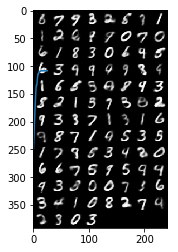

In [893]:
with torch.no_grad():
    ls = []
    start = 1
    end = glm.max_K
    for k in range(start,end):
        loss = 0
        for i, data in enumerate(trainloader, 10):
            images, labels = data
            images = images.to(device)
            recon_image, z, gi, pi, nu, a_code, mu, log_var = glm(images, k)

            recon_image_ = recon_image.view(BATCH_SIZE, 1, 28, 28)

            loss += F.binary_cross_entropy(recon_image, images.view(-1, 784), reduction='sum')
        loss /= 60000
        print("Loss for k = ",k," is ", loss)
        ls.append(loss.detach().numpy())
    
    show_images(recon_image_)
    plt.plot(ls)

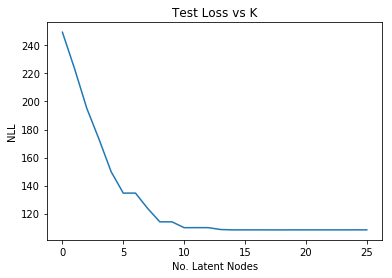

In [900]:
plt.plot(ls[:], label = "Test Loss")
plt.xlabel("No. Latent Nodes")
plt.ylabel("NLL")
plt.title("Test Loss vs K")
plt.savefig("mnist_loss")

In [932]:
with torch.no_grad():
    recon_image, z, gi, pi, nu, a, mu, logs = glm(images, 19)
    recon_image_ = recon_image.view(BATCH_SIZE, 1, 28, 28)

tensor(0.)
tensor(0.9979)


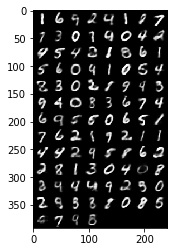

In [933]:
show_images(recon_image_)
plt.savefig("grid")

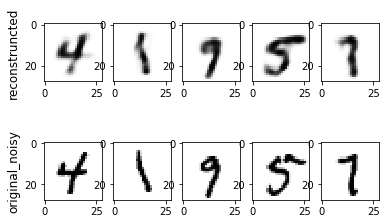

In [941]:
fig, ax = plt.subplots(2,5)
for k in range(5):
    
    idx = np.random.choice(np.arange(gi.shape[0]))

    z = ax[0][k].imshow(1-recon_image[idx,:].view(28,28).detach())
    z = ax[1][k].imshow(1-images[idx,:].view(28,28).detach())

ax[0][0].set_ylabel('reconstruncted', rotation=90, size='large')
ax[1][0].set_ylabel('original_noisy', rotation=90, size='large')
plt.savefig('Recons')
plt.show()

In [937]:
def get_rho_prob(rhos):
    
    rho_np = rhos.detach().numpy().reshape(-1)
    mt = rho_np.copy()
    
    for i in range(1,mt.shape[0]):
        prod = 1
        for j in range(i):
            prod*=rhos[j]
    
        mt[i-1] = prod*(1-rhos[i])

    return mt

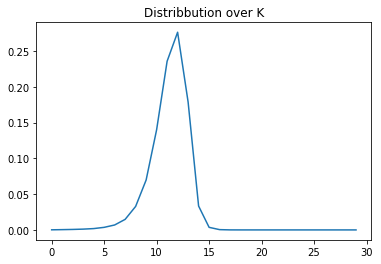

In [938]:
plt.plot(get_rho_prob(glm.rhos)[:-1])
plt.title("Distribbution over K")
plt.savefig("dist_K.png")